## Available:
1. black list: wont change the black listed columns
2. early stopping
3. one hot encoded inputs
4. Correct Black list, now it is applied on the one_hot list not the input columns. 

## TODO:
1. The node labels are out of the figure

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(555)

import matplotlib.pyplot
plt.style.use('ggplot')

In [3]:
from alibi.utils.mapping import (
    ohe_to_ord as alibi_ohe_to_ord,
    ord_to_ohe as alibi_ord_to_ohe,
)

In [4]:
data = pd.read_csv('german_credit.csv')
y = data['default']
X_df = data.drop('default', axis=1)

cats = [X_df.dtypes.index[i] for i in range(X_df.shape[1]) if X_df.dtypes[i]=='object']
X_df = pd.get_dummies(X_df, columns=cats)

X = X_df.values
y = y.values

X_df.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes
0,6,1169,4,4,67,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1
1,48,5951,2,2,22,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
2,12,2096,2,3,49,1,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1
3,42,7882,2,4,45,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1
4,24,4870,3,4,53,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1


In [5]:
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

# logistic = SGDClassifier(loss='log', penalty='l1', early_stopping=True,
#                          max_iter=10000, tol=1e-5, random_state=0)
# sca = MinMaxScaler()
# clf = Pipeline(steps=[('sca', sca), ('logistic', logistic)])
# clf.fit(X,y)
# clf.score(X,y)

0.775

In [6]:
from ga_attack import plot_graph, create_onehot_map, GA_Counterfactual, alibi_ord_to_ohe, GAdvExample, alibi_ord_to_ohe

In [121]:
feature_names = list(X_df.columns)

In [122]:
ord_names, one_hot = create_onehot_map(feature_names, sep="_", min_dist=1, data=None)
ord_names

['account_check_status',
 'credit_history',
 'purpose',
 'savings',
 'present_emp_since',
 'personal_status_sex',
 'other_debtors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker']

In [123]:
data_, ord_enc = alibi_ohe_to_ord(X_train, one_hot)
data_.shape, X_train.shape

((600, 20), (600, 61))

In [10]:
np.quantile(data_[:,0], np.linspace(0,1,5))

array([ 4., 12., 18., 24., 72.])

In [11]:
np.where(clf.predict(X_train)!=y_train)

(array([], dtype=int64),)

In [138]:
np.where(clf.predict_proba(X_test)[:,1]>0.6)

(array([  9,  16,  42,  51,  64,  71,  72,  74,  76, 108, 173, 209, 210,
        232, 236, 243, 245, 271, 292, 306, 315, 319, 323, 327, 329, 343,
        350, 357, 358, 361, 378, 380]),)

In [167]:
idx_test = 76
ga = GAdvExample(feature_names=feature_names,
                sol_per_pop=35, num_parents_mating=15, cat_vars_ohe=one_hot,
                 num_generations=200, n_runs=10, black_list=None,
                 verbose=False, beta=.97)

x_all, x_changes, x_sucess = ga.attack(clf, x=X_test[idx_test,:],x_train=X_train)

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


In [168]:
ga.results

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes,P0,P1
0,12.000000,1858.000000,4.000000,1.000000,22.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.370000,0.630000
1,12.000000,1858.000000,4.000000,1.000000,22.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.540000,0.460000
2,12.000000,1858.000000,4.000000,1.000000,22.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.580000,0.420000
4,12.000000,1858.000000,4.000000,1.000000,22.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000

In [171]:
df = pd.DataFrame(alibi_ohe_to_ord(ga.results.data.values, ga.cat_vars_ohe)[0].astype(int), columns=list(x_changes.columns) + ["P0", "Pred. Proba"]).drop(columns=["P0"])
print(df.T.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     0 &     1 &     2 &     3 \\
\midrule
duration\_in\_month          &    12 &    12 &    12 &    12 \\
credit\_amount              &  1858 &  1858 &  1858 &  1858 \\
installment\_as\_income\_perc &     4 &     4 &     4 &     4 \\
present\_res\_since          &     1 &     1 &     1 &     1 \\
age                        &    22 &    22 &    22 &    22 \\
credits\_this\_bank          &     1 &     1 &     1 &     1 \\
people\_under\_maintenance   &     1 &     1 &     1 &     1 \\
account\_check\_status       &     1 &     1 &     2 &     1 \\
credit\_history             &     3 &     3 &     3 &     3 \\
purpose                    &     7 &     7 &     7 &     7 \\
savings                    &     1 &     0 &     1 &     1 \\
present\_emp\_since          &     1 &     1 &     1 &     1 \\
personal\_status\_sex        &     0 &     0 &     0 &     0 \\
other\_debtors              &     2 &     2 &     2 &     1 \\
property                   &     

In [170]:
plot_graph(x_changes, 0, figsize=(7,7), save=True)

No edges exist!


In [15]:
feat_ord = list(x_changes.columns)
feat_ord

['duration_in_month',
 'credit_amount',
 'installment_as_income_perc',
 'present_res_since',
 'age',
 'credits_this_bank',
 'people_under_maintenance',
 'account_check_status',
 'credit_history',
 'purpose',
 'savings',
 'present_emp_since',
 'personal_status_sex',
 'other_debtors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker']

In [16]:
# blist = [i for i in range(len(feat_ord)) if ("age" not in feat_ord[i]) and ("foreign_worker" not in feat_ord[i]) and ("personal_status_sex" not in feat_ord[i]) ]
# blist = [i for i in range(len(feat_ord)) if ("account_check_status" in feat_ord[i]) or ("purpose" in feat_ord[i]) or ("credit_history" in feat_ord[i]) ]
blist = []

In [17]:
blist

[]

In [18]:
ga = GAdvExample(feature_names=feature_names,
                sol_per_pop=35, num_parents_mating=15, cat_vars_ohe=one_hot,
                 num_generations=200, n_runs=1, black_list=blist,
                 verbose=False, beta=0.95)

results = []

for xi in X_test:
    x_all, x_changes, x_sucess = ga.attack(clf, x=xi,x_train=X_train)
    if len(x_sucess)>0:
        results.append((xi,x_changes, x_sucess))
    print(len(x_sucess))

  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

1



  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

1
1



  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

1


In [19]:
len(results)

400

In [ ]:
adv = []
data = []
for result in results:
    for xi in result[2]:
        adv.append(xi)
        data.append(result[0])

In [45]:
# import pickle
# pickle.dump((clf, results), open("distribution_change_res.pkl","wb"))

In [58]:
adv = []
data = []
for result in results:
    for xi in result[2]:
        adv.append(alibi_ord_to_ohe(xi.reshape(1,-1), ord_enc)[0][0])
        data.append(result[0])

In [59]:
predprob_data = clf.predict_proba(data)[:,1]
predprob_adv = clf.predict_proba(adv)[:,1]
pred = clf.predict(data)

Text(0, 0.5, 'Counts')

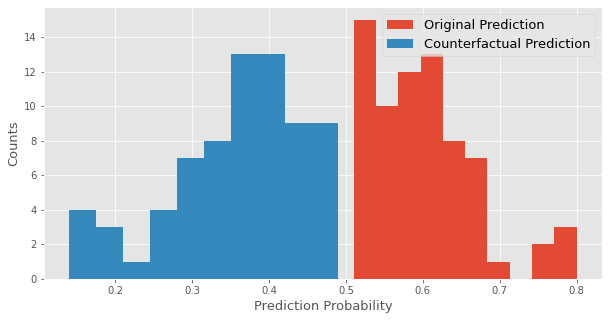

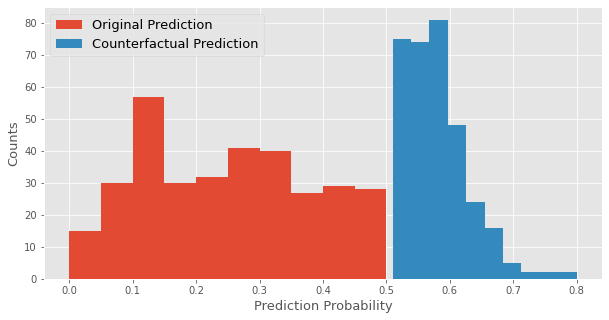

In [71]:
fig = plt.figure(figsize=(10,5))
_ = plt.hist(predprob_data[pred==1], label="Original Prediction")
_ = plt.hist(predprob_adv[pred==1], label="Counterfactual Prediction")
plt.legend(loc='best', fontsize=13)
fig.gca().set_xlabel("Prediction Probability", fontsize=13)
fig.gca().set_ylabel("Counts", fontsize=13)

fig = plt.figure(figsize=(10,5))
_ = plt.hist(predprob_data[pred==0], label="Original Prediction")
_ = plt.hist(predprob_adv[pred==0], label="Counterfactual Prediction")
plt.legend(loc='best', fontsize=13)
fig.gca().set_xlabel("Prediction Probability", fontsize=13)
fig.gca().set_ylabel("Counts", fontsize=13)

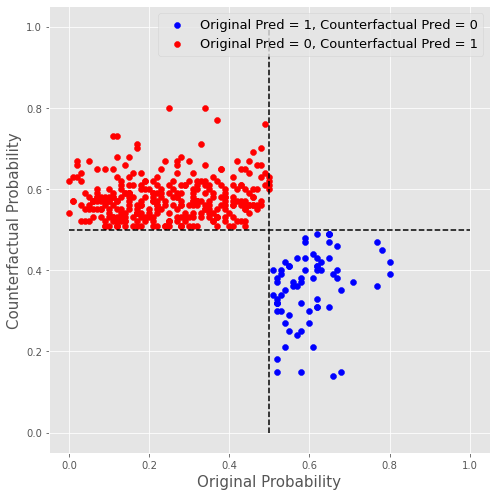

In [91]:
fig = plt.figure(figsize=(7,7))


plt.scatter(predprob_data[pred==1], predprob_adv[pred==1], c="b", vmin=0, vmax=1, label = "Original Pred = 1, Counterfactual Pred = 0")
plt.scatter(predprob_data[pred==0], predprob_adv[pred==0], c="r", vmin=0, vmax=1, label = "Original Pred = 0, Counterfactual Pred = 1")

plt.hlines(0.5, 0, 1, linestyles="--")
plt.vlines(0.5, 0, 1, linestyles="--")

plt.legend(loc='best', fontsize=13)
fig.gca().set_xlabel("Original Probability", fontsize=15)
fig.gca().set_ylabel("Counterfactual Probability", fontsize=15)
plt.tight_layout()
plt.savefig("scatter_outcomes.png", type="png", dpi=600)

In [22]:
x_change_all = results[0][1]
for result in results[1:]:
    x_change_all = pd.concat([x_change_all, result[1]])
    
x_change_all.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status,credit_history,purpose,savings,present_emp_since,personal_status_sex,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker
0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,-1,0,0
0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0
0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0


In [23]:
adv = np.asarray(adv)
data = np.asarray(data)
adv.shape

(400, 20)

In [24]:
data_, hot_one = alibi_ohe_to_ord(data, one_hot)
data_.shape, data.shape

((400, 20), (400, 61))

In [25]:
(clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])==1).sum(), (clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])==0).sum()

(329, 71)

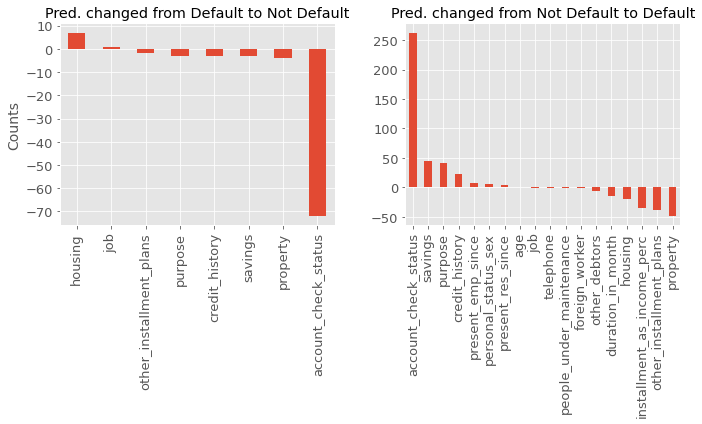

In [26]:
plt.figure(figsize=(10,6))
ax= plt.subplot(1,2,1)

ind = clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])==0
df1 = (x_change_all[ind]).sum(0).to_frame().sort_values(by=0,ascending=False)
ax = df1[df1[0]!=0].plot.bar(legend=False, fontsize=13, ax = ax)
ax.set_ylabel("Counts", fontsize=14)
ax.set_title("Pred. changed from Default to Not Default")
ax = plt.subplot(1,2,2)
ind = clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])==1
df2 = (x_change_all[ind]).sum(0).to_frame().sort_values(by=0,ascending=False)
df2[df2[0]!=0].plot.bar(legend=False, fontsize=13, ax=ax)
ax.set_title("Pred. changed from Not Default to Default")

plt.tight_layout()
# plt.savefig("sensitive_germancredit.png", type="png", dpi=600)

In [27]:
adv[ind,-1]

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

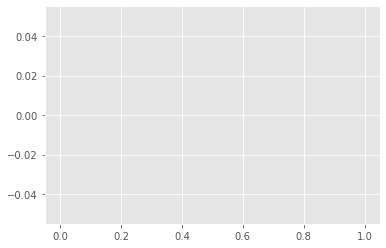

In [28]:
ind = clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])==0
df = x_change_all.loc[ind, "foreign_worker"]
df[df!=0].hist()

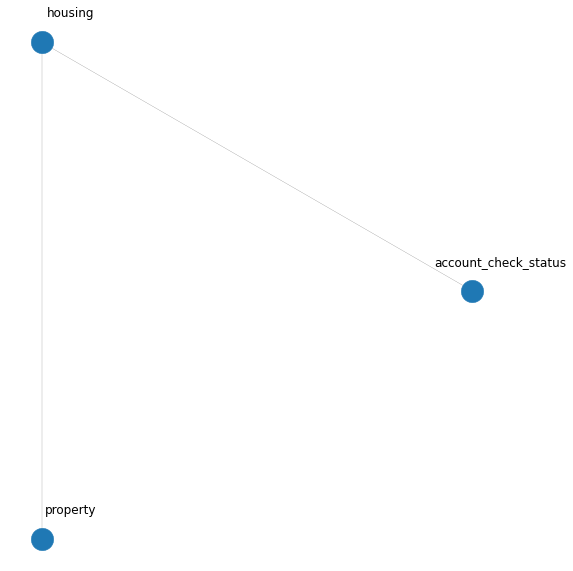

In [29]:
ind = clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])==0

plot_graph(x_change_all[ind], 0, figsize=(8,8), save=True)

In [30]:
data_.shape

(400, 20)

In [31]:
change = data_!=adv

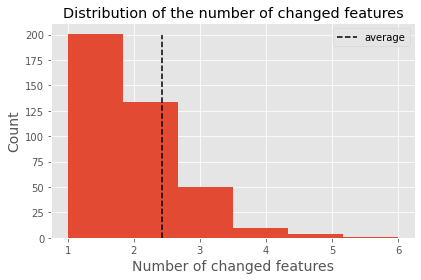

In [32]:
n, bins,_ = plt.hist(change.sum(1), bins=6)
plt.gca().set_xlabel("Number of changed features", fontsize=14)
plt.gca().set_ylabel("Count", fontsize=14)
plt.title("Distribution of the number of changed features")
plt.vlines(np.sum(bins[1:]*n)/np.sum(n), 0, 200, "k", "--", label="average")
plt.legend()
plt.tight_layout()
plt.savefig("chenge_freq.svg", type="svg")
# plt.savefig("chenge_freq.png", type="png", dpi=600)

In [33]:
np.sum(bins[1:]*n)/np.sum(n)

2.427083333333334

In [34]:
(clf.predict(alibi_ord_to_ohe(data_, hot_one)[0]) == clf.predict(alibi_ord_to_ohe(adv, hot_one)[0])).sum()

0

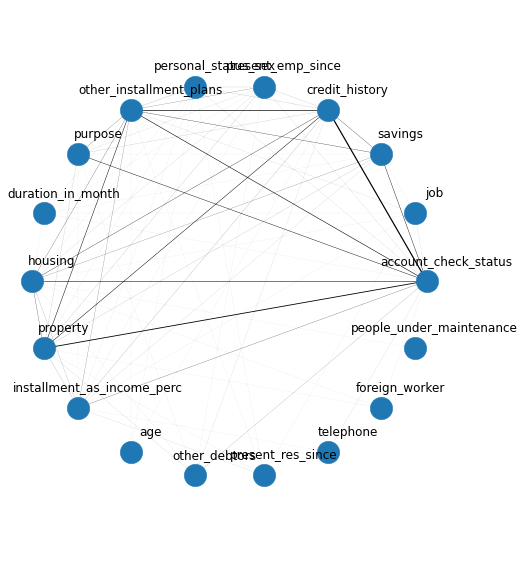

In [35]:
plot_graph(x_change_all, 0, figsize=(8,8), save=True)

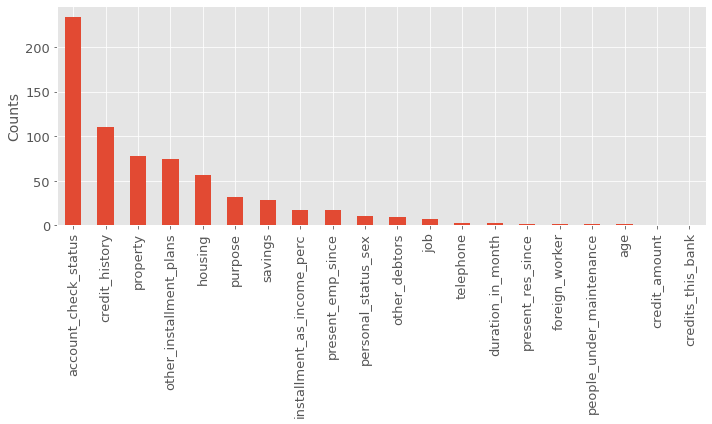

In [36]:
ax = (x_change_all!=0).sum(0).to_frame().sort_values(by=0,ascending=False).plot.bar(legend=False, figsize=(10,6),fontsize=13)
ax.set_ylabel("Counts", fontsize=14)
plt.tight_layout()
# plt.savefig("feat_change_hist.png", type="png", dpi=600)

# SHAP Analysis

In [37]:
import shap

In [38]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns=feature_names))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [39]:
df_shap = pd.DataFrame([np.abs(shap_values[0]).sum(0)], columns = feature_names)
df_shap

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes
0,13.228625,8.178123,4.098975,2.140119,5.157096,1.370633,1.190621,5.931064,19.933499,1.005349,18.504337,2.657122,11.395156,0.630917,1.792658,1.82789,2.642617,1.840977,4.761337,2.074912,4.5581,0.37743,0.11571,1.888181,0.151703,0.099133,0.802638,6.428612,1.718809,0.751202,4.111296,1.872205,2.998317,2.52468,2.715324,0.799875,4.221522,0.509152,0.742043,4.089321,0.711412,0.96471,0.669205,2.064798,2.036309,6.779368,5.53104,1.853671,6.093097,2.293244,1.342508,7.819567,3.863635,1.003496,1.6092,0.124181,0.743713,1.248319,1.283912,0.630858,0.698077


In [40]:
shap_sum = []
for i in range(list(one_hot.keys())[0]):
    shap_sum.append(df_shap.iloc[0,i])
    
for i,v in one_hot.items():
    shap_sum.append(np.sum(df_shap.iloc[0,i:i+v]))

df_shap_sum = pd.DataFrame([shap_sum], columns=x_change_all.columns)
df_shap_sum

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status,credit_history,purpose,savings,present_emp_since,personal_status_sex,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker
0,13.228625,8.178123,4.098975,2.140119,5.157096,1.370633,1.190621,45.374249,18.303743,18.5101,13.812556,10.910401,9.562037,2.345327,16.411515,10.240013,13.02571,3.480589,2.532231,1.328935


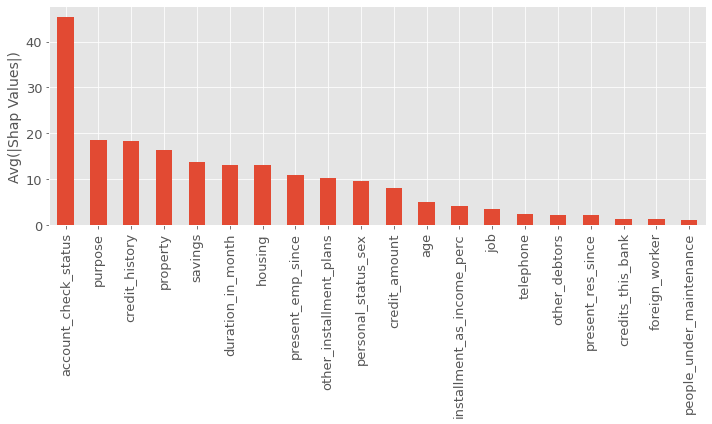

In [41]:
ax = df_shap_sum.T.sort_values(by=0, ascending=False).plot.bar(legend=False, figsize=(10,6),fontsize=13)
ax.set_ylabel("Avg(|Shap Values|)", fontsize=14)
plt.tight_layout()
# plt.savefig("shap_value_importance.png", type="png", dpi=600)

In [42]:
x_change_bin = (x_change_all!=0)
x_change_bin.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status,credit_history,purpose,savings,present_emp_since,personal_status_sex,other_debtors,property,other_installment_plans,housing,job,telephone,foreign_worker
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
0,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,False
0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False


In [43]:
len(x_change_bin[(x_change_bin["property"]==1) & (x_change_bin["account_check_status"])])

33

In [44]:
len(x_change_bin[(x_change_bin["job"]==1) & (x_change_bin["account_check_status"])])

2